In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -a 'Marcos Santana' -d -p numpy,pandas,rdkit,fastai,torch -v

Author: Marcos Santana

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy : 1.20.1
pandas: 1.2.4
rdkit : 2021.03.5
fastai: 2.5.2
torch : 1.9.0



In [2]:
import pandas as pd
import numpy as np
from fastai.text.all import *

# Load data

In [20]:
data = pd.read_csv('../data/LSTM_pretraining_data.txt',header=None,names=['Smiles']).sample(n=10000)

In [21]:
data.head()

,Smiles
157271,CC(C(=O)Nc1ccc(CCN2CCOC2=O)cc1)c1cccs1
446736,Cc1[nH]nc(C(=O)N2CCCCCCC2)c1[N+](=O)[O-]
129818,O=C(NNC(=O)c1ccccc1SC(F)F)c1ccccc1O
341374,CNC(=S)N(Cc1ccc(F)cc1)Cc1cc2cc(C)ccc2[nH]c1=O
51659,COC(=O)C(=Cc1ccc([N+](=O)[O-])cc1)NC(=O)c1ccc(C)cc1


# Tokenizer

We'll use a custom tokenizer to split each SMILES into individual characters. Two-lettered elements and special enviroments (e.g. [C@@]) will remain as a single tokens.

In [22]:
import re

class MolTokenizer_V2():

  def tokenize_mols(self, t):
    BOS = 'xxbos'
    pat = '(\[.*?\])' # Find special enviroments (e.g., [CH],[NH] etc)
    tokens = []
    t = t.replace('Br','L').replace('Cl','X') # Replace halogens
    atom_list = re.split(pat,t)
    for s in atom_list:
      if s.startswith('['):
        tokens.append(s)
      else:
        tokens += [x for x in list(s)]
    tokens = [x.replace('L','Br').replace('X','Cl') for x in tokens] # Decode halogens
    return [BOS] + tokens

  def __call__(self, items): return (self.tokenize_mols(t) for t in items)

**Testing the tokenizer**

In [23]:
tok = Tokenizer(tok=MolTokenizer_V2(),rules=[]) # Fastai has a very handy wrapper Tokenizer class. 

In [24]:
tokens = L(data.Smiles.tolist()[0:10]).map(tok)

In [25]:
' '.join(tokens[0])

'xxbos C C ( C ( = O ) N c 1 c c c ( C C N 2 C C O C 2 = O ) c c 1 ) c 1 c c c s 1'

# Text dataloader

In [26]:
splitter = RandomSplitter(0.10)
spec_toks = [BOS, PAD]
text_col = 'Smiles'
tfms = [attrgetter(text_col),
        Tokenizer.from_df(text_cols=text_col,tok=MolTokenizer_V2(),rules=[],tok_text_col=text_col),
        Numericalize(min_freq = 1, special_toks=spec_toks)]
dst = Datasets(data, tfms=[tfms], splits = splitter(data), dl_type=LMDataLoader)

/home/marcossantana/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [27]:
dls = dst.dataloaders(bs=64,seq_len=30)

In [28]:
dls.show_batch()

,text,text_
0,xxbos O = C ( C C 1 C C C C 1 ) O C c 1 n c 2 c c c c c 2 s 1 xxbos,O = C ( C C 1 C C C C 1 ) O C c 1 n c 2 c c c c c 2 s 1 xxbos C
1,c 1 c ( F ) c c c c 1 C ( = O ) N C ( C ) C ( = O ) O xxbos C O,1 c ( F ) c c c c 1 C ( = O ) N C ( C ) C ( = O ) O xxbos C O C
2,C 1 2 C C N ( C c 1 c n ( C ) c 3 c c c c c 1 3 ) C C 2 xxbos C,1 2 C C N ( C c 1 c n ( C ) c 3 c c c c c 1 3 ) C C 2 xxbos C C
3,C ( = O ) N C C N 2 C C C C C 2 C O ) c ( - c 2 c c c c c 2,( = O ) N C C N 2 C C C C C 2 C O ) c ( - c 2 c c c c c 2 )
4,c c c ( F ) c c 1 ) C 1 C C 1 ) N c 1 c c c ( F ) c c 1 Cl xxbos,c c ( F ) c c 1 ) C 1 C C 1 ) N c 1 c c c ( F ) c c 1 Cl xxbos C
5,O ) N c 1 c c c c c 1 O C ( = O ) C ( C # N ) = C c 1 c c c,) N c 1 c c c c c 1 O C ( = O ) C ( C # N ) = C c 1 c c c 2
6,C C ( = O ) N c 1 s c 2 c ( c 1 C ( = O ) O C C ( = O ) c 1,C ( = O ) N c 1 s c 2 c ( c 1 C ( = O ) O C C ( = O ) c 1 [nH]
7,) C N ( C ) C ( = O ) c 2 c c 3 c c c c c 3 [nH] 2 ) c 1 xxbos C c,C N ( C ) C ( = O ) c 2 c c 3 c c c c c 3 [nH] 2 ) c 1 xxbos C c 1
8,c c c c ( - c 2 c n c ( - c 3 c c n c c 3 ) n c 2 C 2 C C N,c c c ( - c 2 c n c ( - c 3 c c n c c 3 ) n c 2 C 2 C C N (


# Train generative model

We'll not use a pretrained model in this notebook. Let's just train from scratch. 

In [29]:
metrics = [accuracy]

In [30]:
learn = language_model_learner(dls, AWD_LSTM,pretrained=False,metrics=metrics,
                               drop_mult=0.75)#.load_pretrained(pretrained_path,vocab_path)
learn.unfreeze()

**Learning rate finder**

SuggestedLRs(valley=0.0003521005273796618)

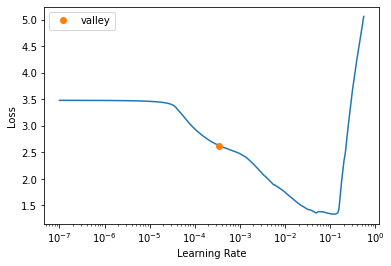

In [31]:
learn.lr_find(num_it=600)

**Training using optimal learning rate**

In [34]:
learn.fit_one_cycle(n_epoch=20,lr_max=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.749619,1.444476,0.526141,00:51
1,1.141663,0.998605,0.664848,00:52
2,0.915900,0.843609,0.703997,00:52
3,0.807525,0.773743,0.728835,00:53
4,0.773417,0.738951,0.735749,00:53
5,0.725979,0.705553,0.750752,00:53
6,0.693990,0.703743,0.752706,00:52
7,0.658255,0.679785,0.756202,00:52
8,0.650214,0.674251,0.761680,00:51
9,0.633850,0.660845,0.764958,00:55
